# Processing ERA5 data in NetCDF Format

This notebook demonstrates how to work with the ECMWF ERA5 reanalysis available as part of the AWS Public Dataset Program (https://registry.opendata.aws/ecmwf-era5/).

This notebook utilizes Amazon SageMaker & AWS Fargate for providing an environment with a Jupyter notebook and Dask cluster. There is an example AWS CloudFormation template available at https://github.com/awslabs/amazon-asdi/tree/main/examples/dask for quickly creating this environment in your own AWS account to run this notebook.

## Python Imports

In [1]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

Install extra software here, if necessary

In [2]:
#import sys
#!{sys.executable} -m pip install graphviz
#import graphviz

## Set up the Dask Client to talk to our Fargate Dask Distributed Cluster

This notebook expects Dask to be running in an ECS cluster.  There is an example AWS CloudFormation template available at https://github.com/awslabs/amazon-asdi/tree/main/examples/dask for quickly creating this environment in your own AWS account to run this notebook.  The code in this notebook assumes you are running in this environment and will need adjusting if you are using a different Dask setup.

**Update the stackname variable below to identify the name of your CloudFormation stack**

In [3]:
stackname="dask-202211"

# Retrieve stack outputs
cfn = boto3.client('cloudformation')
resp = cfn.describe_stacks(StackName=stackname)
outputs = {}
for output in resp['Stacks'][0]['Outputs']:
    outputs[output['OutputKey']] = output['OutputValue']
cluster = outputs['DaskECSClusterName']
schedulerservice = outputs['DaskSchedulerServiceName']
workerservice = outputs['DaskWorkerServiceName']
outputs

{'DaskWorkerServiceName': 'dask-202211-DaskFargateWorkerService-R0Eqt1KehPm0',
 'DaskECSClusterName': 'dask-202211-ECSCluster',
 'DaskSchedulerSecurityGroup': 'sg-03e009505e8b59936',
 'DaskSchedulerServiceName': 'dask-202211-DaskSchedulerService-7PBwrlyInl3e',
 'JupyterNotebook': 'https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/notebook-instances/openNotebook/DaskNotebook-zJK4Wb3nZCE1?view=lab'}

Start the dask scheduler service through ECS

In [4]:
ecs = boto3.client('ecs')
ecs.update_service(cluster=cluster, service=schedulerservice, desiredCount=1)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=[schedulerservice])

The following will identify the public IP address of the Dask-Scheduler task (based on security group membership) and output the dashboard URL:

In [5]:
ec2 = boto3.client('ec2')
resp = ec2.describe_network_interfaces(
  Filters=[{
      'Name': 'group-id',
      'Values': [outputs['DaskSchedulerSecurityGroup']]
  }])
schedulerurl = 'http://' + resp['NetworkInterfaces'][0]['Association']['PublicDnsName'] + '/status'
from IPython.display import display,HTML
display(HTML('Dask scheduler URL - click to open in new tab: <a href=\'' + schedulerurl + '\'>' + schedulerurl + '</a>'))

### Scale out Dask Workers and connect
Start the dask worker tasks and connect to the scheduler.  This will take a minute or so.

In [6]:
numWorkers=12
ecs.update_service(cluster=cluster, service=workerservice, desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=[workerservice])

In [7]:
client = Client('dask-scheduler.local-dask:8786')
client

<Client: 'tcp://10.10.58.181:8786' processes=12 threads=24, memory=78.23 GiB>

Enable fsspec debugging if desired.  This will increase the work log output but can be helpful to identify inefficient S3 access.  Worker log output can be found in CloudWatch Logs.

In [8]:
#client.run(fsspec.utils.setup_logging, logger_name="fsspec", level="DEBUG")

## Open an Example File and Check the Native Chunking

Before we start processing lets explore the dataset to discover its structure and chunking layout.  We want to chunk in an aligned way for maximum performance.

First list the NetCDF files for a single month in the ERA5 public S3 bucket, using `s3fs`.

In [9]:
fs = s3fs.S3FileSystem(anon=True)
fs.ls('era5-pds/2021/01/data')

['era5-pds/2021/01/data/air_pressure_at_mean_sea_level.nc',
 'era5-pds/2021/01/data/air_temperature_at_2_metres.nc',
 'era5-pds/2021/01/data/air_temperature_at_2_metres_1hour_Maximum.nc',
 'era5-pds/2021/01/data/air_temperature_at_2_metres_1hour_Minimum.nc',
 'era5-pds/2021/01/data/dew_point_temperature_at_2_metres.nc',
 'era5-pds/2021/01/data/eastward_wind_at_100_metres.nc',
 'era5-pds/2021/01/data/eastward_wind_at_10_metres.nc',
 'era5-pds/2021/01/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc',
 'era5-pds/2021/01/data/lwe_thickness_of_surface_snow_amount.nc',
 'era5-pds/2021/01/data/northward_wind_at_100_metres.nc',
 'era5-pds/2021/01/data/northward_wind_at_10_metres.nc',
 'era5-pds/2021/01/data/precipitation_amount_1hour_Accumulation.nc',
 'era5-pds/2021/01/data/sea_surface_temperature.nc',
 'era5-pds/2021/01/data/sea_surface_wave_from_direction.nc',
 'era5-pds/2021/01/data/sea_surface_wave_mean_period.nc',
 'era5-pds/2021/01/data/s

Now lets open one of the files as a dataset using `xarray`, then explore its size, shape and chunk layout.

In [10]:
url = 's3://era5-pds/2021/05/data/air_temperature_at_2_metres.nc'
ncfile = fsspec.open(url)
ds = xr.open_dataset(ncfile.open())
ds.air_temperature_at_2_metres.encoding

{'chunksizes': (24, 100, 100),
 'fletcher32': False,
 'shuffle': True,
 'zlib': True,
 'complevel': 4,
 'source': '<File-like object S3FileSystem, era5-pds/2021/05/data/air_temperature_at_2_metres.nc>',
 'original_shape': (744, 721, 1440),
 'dtype': dtype('<f4'),
 '_FillValue': 9.96921e+36}

In [11]:
ds.info()

xarray.Dataset {
dimensions:
	lon = 1440 ;
	lat = 721 ;
	time0 = 744 ;

variables:
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
	float32 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
	datetime64[ns] time0(time0) ;
		time0:standard_name = time ;
	float32 air_temperature_at_2_metres(time0, lat, lon) ;
		air_temperature_at_2_metres:least_significant_digit = 1 ;
		air_temperature_at_2_metres:standard_name = air_temperature ;
		air_temperature_at_2_metres:units = K ;
		air_temperature_at_2_metres:long_name = 2 metre temperature ;
		air_temperature_at_2_metres:nameECMWF = 2 metre temperature ;
		air_temperature_at_2_metres:shortNameECMWF = 2t ;
		air_temperature_at_2_metres:nameCDM = 2_metre_temperature_surface ;
		air_temperature_at_2_metres:product_type = analysis ;

// global attributes:
	:source = Reanalysis ;
	:institution = ECMWF ;
	:title = ERA5 forecasts ;
}

In [12]:
# Note this causes the file to be read into memory
# print('file size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

### Explore the underlying HDF5 structure
NetCDF version 4 uses HDF5 as the underlying file structure, so you can also use h5py directly to view information about the NetCDF data (assuming it is in netcdf4 / HDF5 format)

In [13]:
import h5py
h5f = h5py.File(fs.open(url))
list(h5f.keys())

['air_temperature_at_2_metres', 'lat', 'lon', 'time0']

Lets take a look at the chunk layout and size information

In [14]:
ds = h5f['air_temperature_at_2_metres']
print("Number of chunks in file dataset:", ds.id.get_num_chunks())
print("Dataset shape:", ds.shape)
print("Chunk shape:", ds.chunks)
print("Compression:", ds.compression)
print("Dataset storage size: {:0.2f} MB".format(ds.id.get_storage_size() / 1e6))
print("Dataset full size: {:0.2f} MB".format(ds.nbytes / 1e6))

Number of chunks in file dataset: 3720
Dataset shape: (744, 721, 1440)
Chunk shape: (24, 100, 100)
Compression: gzip
Dataset storage size: 486.17 MB
Dataset full size: 3089.80 MB


Now lets have a look at the first few chunks to see how big they are on disk, and get a rough idea of the file layout

In [15]:
for i in range(0,20):
   print(ds.id.get_chunk_info(i))
print(':')
print(ds.id.get_chunk_info(ds.id.get_num_chunks()-1))

StoreInfo(chunk_offset=(0, 0, 0), filter_mask=0, byte_offset=7308451, size=111902)
StoreInfo(chunk_offset=(0, 0, 100), filter_mask=0, byte_offset=4512982, size=109444)
StoreInfo(chunk_offset=(0, 0, 200), filter_mask=0, byte_offset=6646823, size=117679)
StoreInfo(chunk_offset=(0, 0, 300), filter_mask=0, byte_offset=14706279, size=117571)
StoreInfo(chunk_offset=(0, 0, 400), filter_mask=0, byte_offset=5250422, size=112242)
StoreInfo(chunk_offset=(0, 0, 500), filter_mask=0, byte_offset=3043598, size=115829)
StoreInfo(chunk_offset=(0, 0, 600), filter_mask=0, byte_offset=247176, size=103905)
StoreInfo(chunk_offset=(0, 0, 700), filter_mask=0, byte_offset=2172375, size=100444)
StoreInfo(chunk_offset=(0, 0, 800), filter_mask=0, byte_offset=8837601, size=102605)
StoreInfo(chunk_offset=(0, 0, 900), filter_mask=0, byte_offset=9551810, size=117057)
StoreInfo(chunk_offset=(0, 0, 1000), filter_mask=0, byte_offset=3692654, size=132928)
StoreInfo(chunk_offset=(0, 0, 1100), filter_mask=0, byte_offset=67

## Open 2-m air temperature as a single dataset
This is where the real work begins.  We start by defining the set of S3 objects that we are going to process, using a file pattern.  We'll start with a full year of data - 12 files.

In [16]:
start_year = 2020
end_year = 2020
years = list(np.arange(start_year, end_year+1, 1))
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

file_pattern = 's3://era5-pds/{year}/{month}/data/air_temperature_at_2_metres.nc'
files_list = [file_pattern.format(year=year,month=month) for year in years for month in months]
files_list

['s3://era5-pds/2020/01/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/02/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/03/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/04/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/05/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/06/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/07/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/08/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/09/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/10/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/11/data/air_temperature_at_2_metres.nc',
 's3://era5-pds/2020/12/data/air_temperature_at_2_metres.nc']

### Caching

We now open each object as a "file like object" using s3fs, so we use them with xarray and dask.

Depending on how the data is chunked, there are some parameters we can use to control `fsspec` caching that can improve performance.  By default `s3fs` uses `'bytes'` as the cache type, which is a read-ahead cache mechanism that will request and cache an additional 5MB for each chunk read from S3.  This turns out to be inefficient for the ERA5 dataset, because the NetCDF chunks are small (~200k) and not always stored sequentially.  

The `default_block_size` parameter controls how much additional data will be requested from S3.  We've found values of between 256k and 512k to be optimal for the ERA5 dataset, but feel free to experiment.

You can also experiment with other cache types, as implemented here: https://github.com/fsspec/filesystem_spec/blob/master/fsspec/caching.py

In [17]:
# We'll use our cluster to open files for the dataset in parallel across the workers
@dask.delayed
def s3open(path):
    # Note the s3fs block size - this is the amount of data that will be read from s3 with each GetObject request.
    # By default it is 5MB but for ERA5 we have found a 512k block yields more efficient S3 requests and faster performance.
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, default_block_size=512*1024)
    
    # Using the block cache increases worker memory usage but provides better performance.  It may not work as well for very large datasets - experiment with care!
    # By default the block cache contains 32 blocks, so the below gives a 128MB cache per NetCDF file (32 x 4MB)
    #fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, default_cache_type="block", default_block_size=4*1024*1024)
    
    return fs.open(path)

files_mapper = [s3open(path) for path in files_list]

### Chunk sizing
Now initialise the xarray dataset, specifying a chunk size that is a multiple of the underlying NetCDF chunk of 100/100/24. 
We are aiming for ~100MB chunk size as per dask recommendations.  Uncompressed chunks are 960KB so we set our chunks parameter to give us 128x that.

In [18]:
%%time
ds = xr.open_mfdataset(
    files_mapper, 
    engine='h5netcdf', 
    chunks={'lon':400,'lat':200,'time0':384}, # 128x larger than underlying NetCDF chunk
    concat_dim='time0', 
    combine='nested', 
    coords='minimal', 
    compat='override',
    parallel=True
)

CPU times: user 243 ms, sys: 47.1 ms, total: 290 ms
Wall time: 791 ms


In [19]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 36.48



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (lon: 1440, lat: 721, time0: 8784)
Coordinates:
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                        (time0) datetime64[ns] 2020-01-01 ... 2020-1...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(384, 200, 400), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        ERA5 forecasts>

The `ds.info` output above shows us that there are four dimensions to the data: lat, lon, and time0; and two data variables: air_temperature_at_2_metres, and air_pressure_at_mean_sea_level.

Let's check the chunking...

In [20]:
ds.air_temperature_at_2_metres

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 8784, lat: 721,
                                                 lon: 1440)>
dask.array<concatenate, shape=(8784, 721, 1440), dtype=float32, chunksize=(384, 200, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time0    (time0) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Attributes:
    least_significant_digit:  1
    standard_name:            air_temperature
    units:                    K
    long_name:                2 metre temperature
    nameECMWF:                2 metre temperature
    shortNameECMWF:           2t
    nameCDM:                  2_metre_temperature_surface
    product_type:             analysis

## Convert units to C from K
This performs a simple subtraction operation, to convert the temperature unit into Celsius.  The operation will not actually be performed at this stage - not until we try to access the result or make the explicit call to `persist`, below.

In [21]:
ds['air_temperature_at_2_metres'] = (ds.air_temperature_at_2_metres - 273.15)
ds.air_temperature_at_2_metres.attrs['units'] = 'C'
ds.air_temperature_at_2_metres

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 8784, lat: 721,
                                                 lon: 1440)>
dask.array<sub, shape=(8784, 721, 1440), dtype=float32, chunksize=(384, 200, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time0    (time0) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Attributes:
    units:    C

## Read all data into dask worker memory
The following line reads the entire data set into worker memory.  This step is unnecessary at this stage, but it will make all subsequent calculations much faster (at the expense of memory usage!) and is a useful illustration of how dask works.  Otherwise, calculations are done without reading all data into worker memory at once, and data will need to be read back in for each calculation (taking much longer, but using less memory).  

Perform this calculation immediately using the dataset that is already loaded in worker memory

In [22]:
ds = client.persist(ds)
progress(ds)

VBox()

Sometimes data isn't evenly distributed, depending on the dataset and chunk size that we selected.  Here we rebalance the data across workers so that future tasks will make best use of cluster resources.

In [23]:
client.rebalance()

## Calculate the mean 2-m air temperature for the entire dataset
Now let's do some calculations across the entire data set, starting with calculation of the mean for every grid point.

In [24]:
# calculates the mean along the time dimension
temp_mean = ds['air_temperature_at_2_metres'].mean(dim='time0')

The expressions above didn’t actually compute anything. They just build the dask task graph. To do the computations, we call the `persist` method below.

In [25]:
temp_mean

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float32, chunksize=(200, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0

In [26]:
temp_mean = temp_mean.persist()
progress(temp_mean)

VBox()

## Plot Average Surface Temperature
To plot data, we need to read it back into the local notebook python environment.  This is done using the "compute" function.  Once the data is back in local memory, we can use matplotlib to display it visually.  For more information refer to: https://distributed.dask.org/en/latest/manage-computation.html

Text(0.5, 1.0, 'Mean 2-m Air Temperature 2020 - 2020')

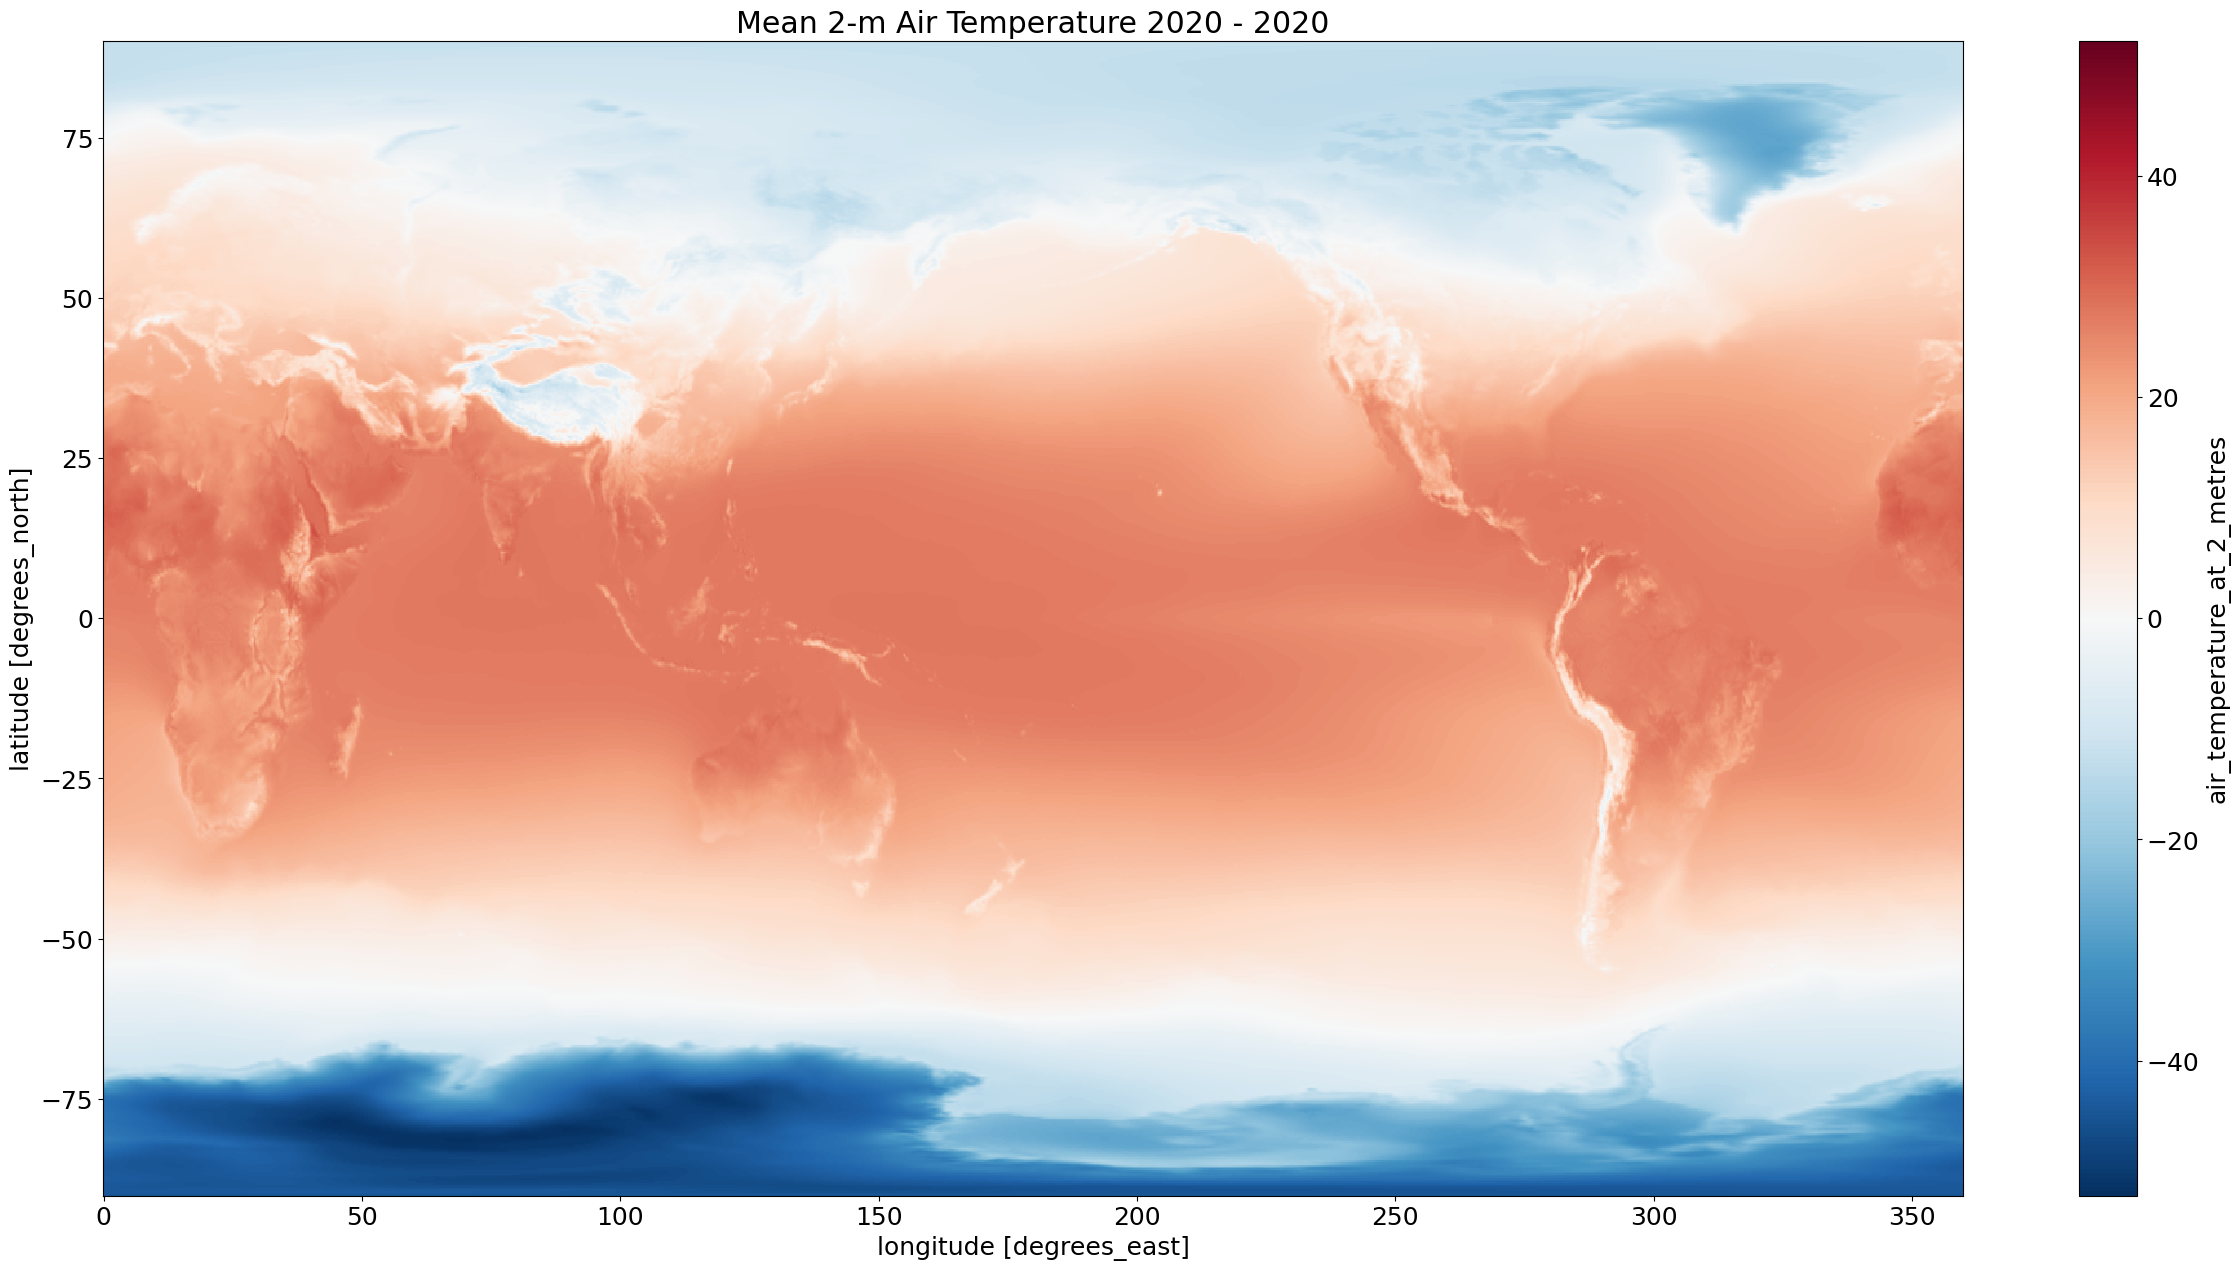

In [27]:
temp_mean.compute()
temp_mean.plot(figsize=(30, 15))
plt.title(f'Mean 2-m Air Temperature {start_year} - {end_year}')

Thats the mean of the hourly sample in the source dataset.  Let's down-sample the data by taking the daily maximum and re-calculating the mean based on that.  This is one line of code...

In [28]:
daily_max_mean = ds['air_temperature_at_2_metres'].resample(indexer={"time0":'D'}).max().mean(dim='time0')
daily_max_mean

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float32, chunksize=(200, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0

We don't necessarily need to call `persist` here, the `compute` call below will trigger this for us - but this lets us see the progress in the notebook.

In [29]:
daily_max_mean = daily_max_mean.persist()
progress(daily_max_mean)

VBox()

Text(0.5, 1.0, 'Average daily maximum temperature 2020 - 2020')

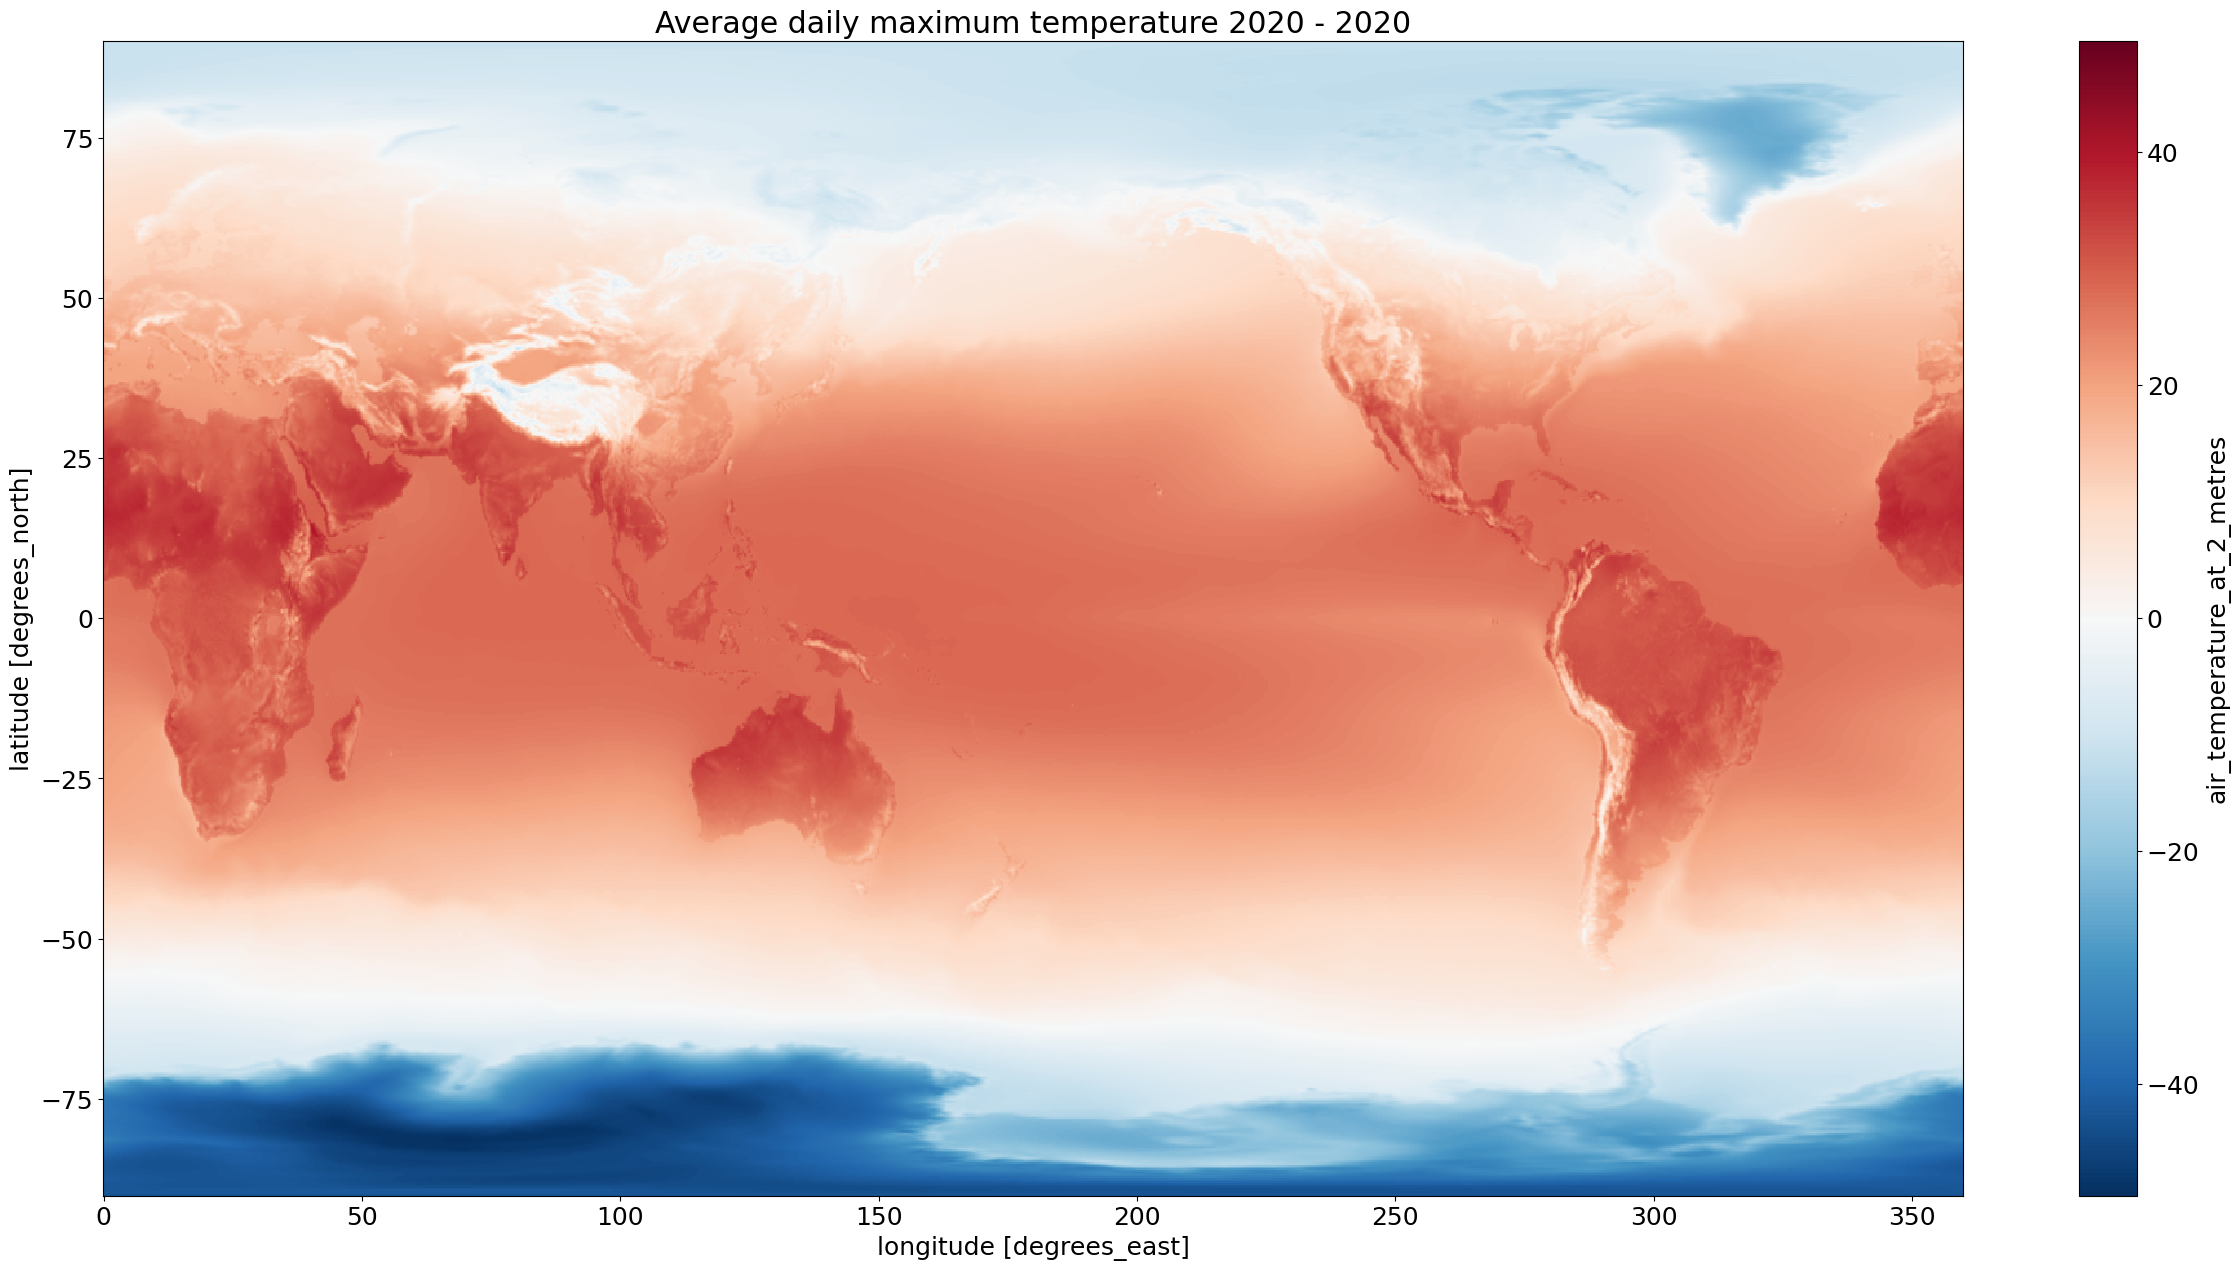

In [30]:
daily_max_mean.compute()
daily_max_mean.plot(figsize=(30, 15))
plt.title(f'Average daily maximum temperature {start_year} - {end_year}')

## Repeat for standard deviation
The data is in memory so let's do another calculation - this time standard deviation!

In [31]:
temp_std = ds['air_temperature_at_2_metres'].std(dim='time0')
temp_std

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
dask.array<_sqrt, shape=(721, 1440), dtype=float32, chunksize=(200, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0

In [32]:
temp_std = temp_std.persist()
progress(temp_std)

VBox()

Text(0.5, 1.0, 'Standard Deviation 2-m Air Temperature 2020 - 2020')

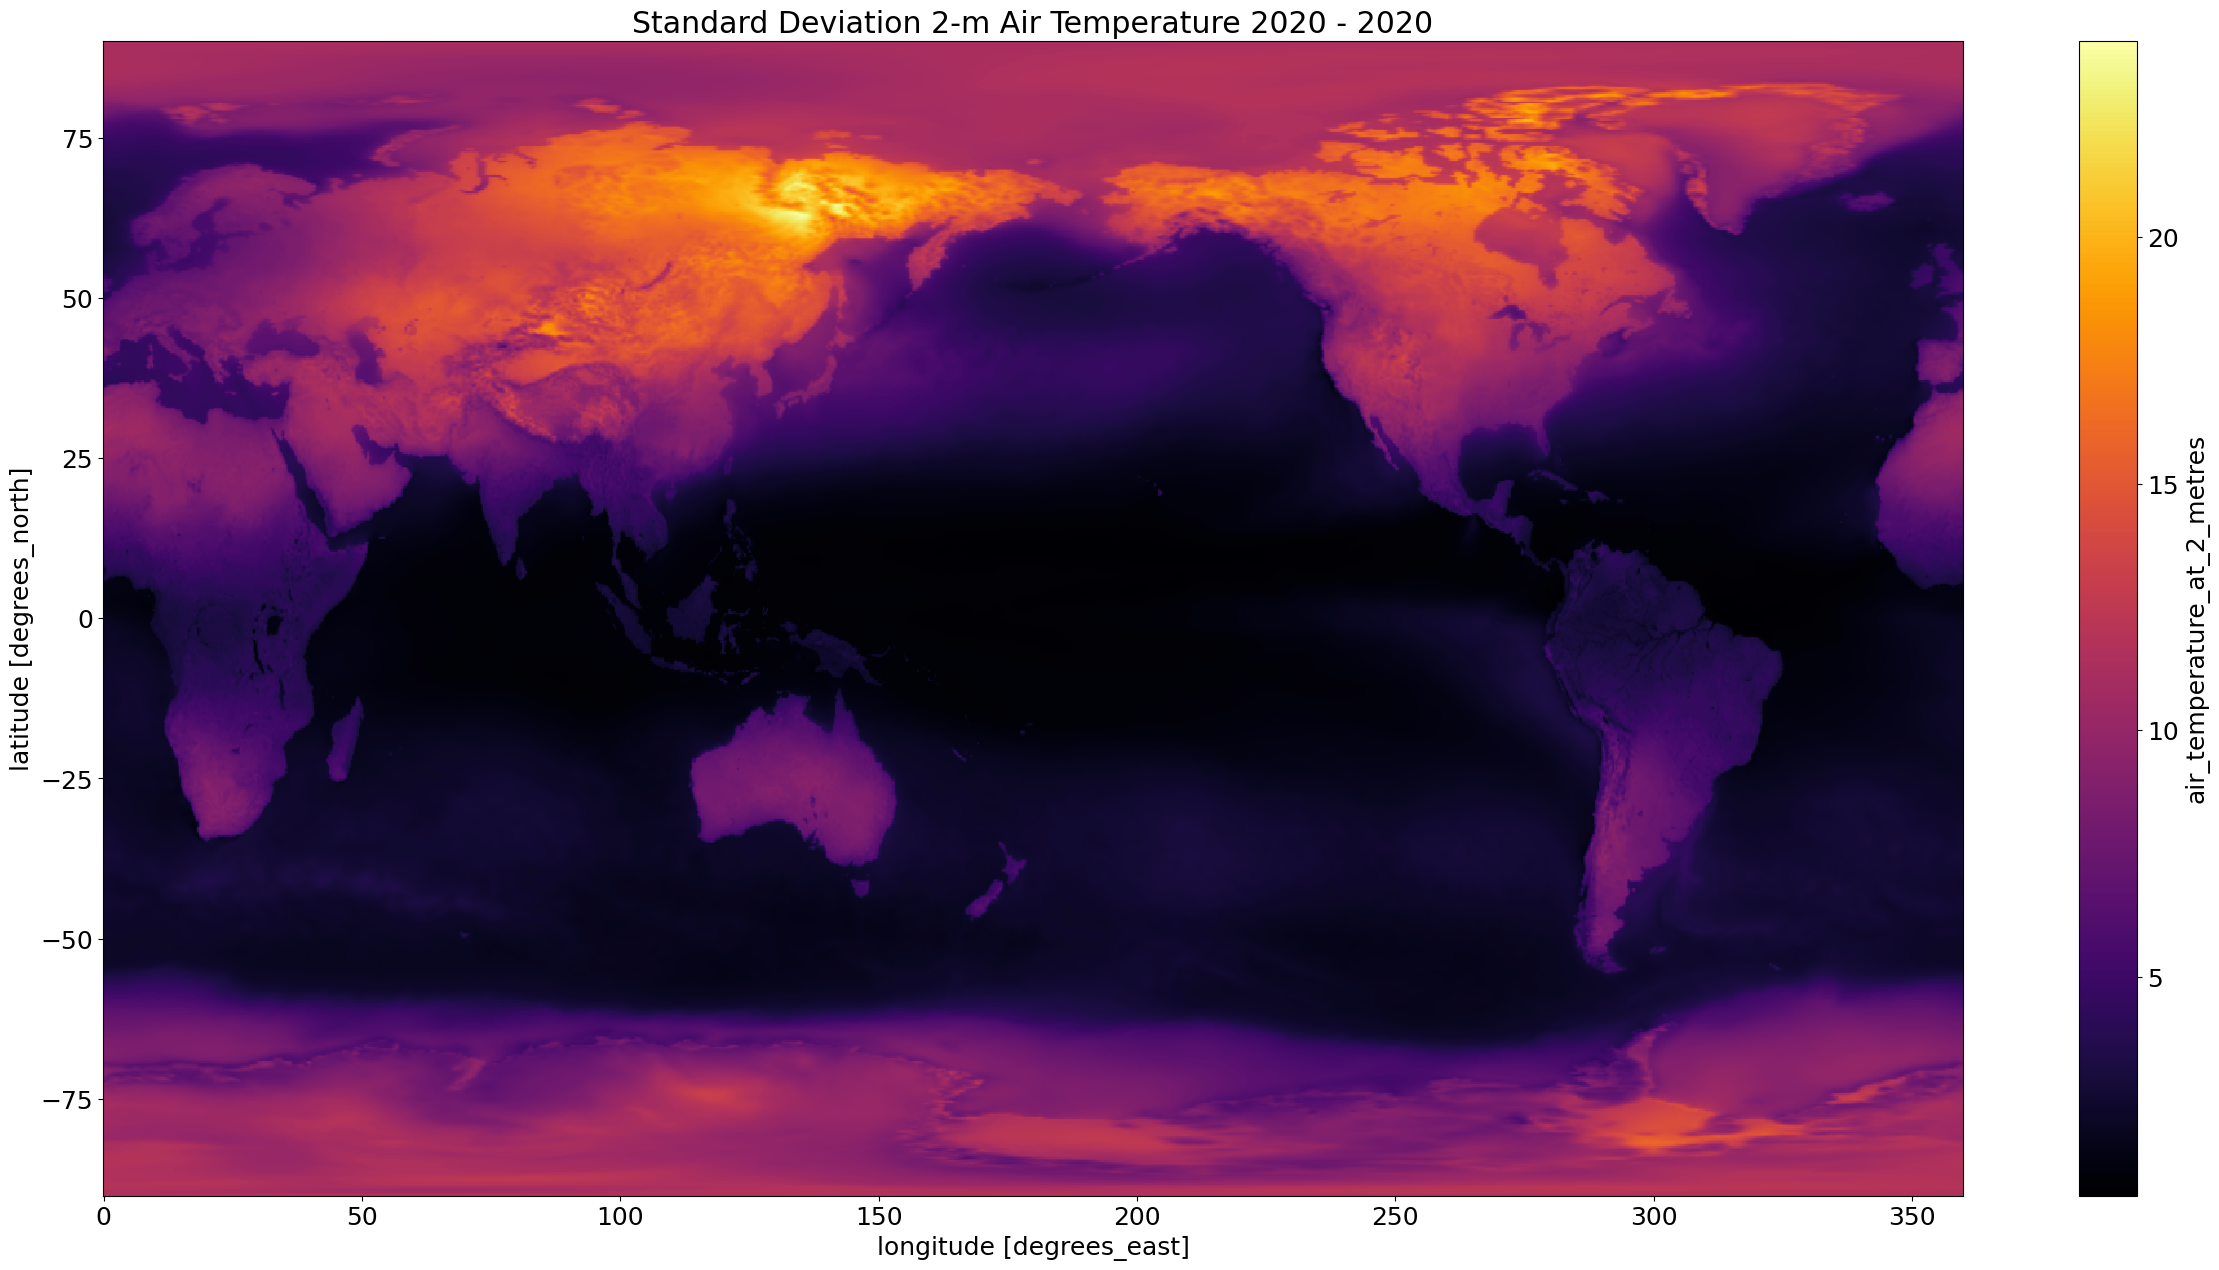

In [33]:
temp_std.compute()
temp_std.plot(figsize=(30, 15),cmap='inferno')
plt.title(f'Standard Deviation 2-m Air Temperature {start_year} - {end_year}')

## Slicing a specific region
This reduces the amount of data we are working with by slicing to a specific region by lat/lon

To do this we use the `xarray.Dataset.sel` function and provide lat/lon slice co-ordinates.  The slice in the code below is for the ANZ region.  Feel free to adjust!

In [34]:
dssubset = ds['air_temperature_at_2_metres'].sel(lat=slice(0,-50),lon=slice(110,180))
dssubset

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 8784, lat: 201, lon: 281)>
dask.array<getitem, shape=(8784, 201, 281), dtype=float32, chunksize=(384, 161, 281), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 179.2 179.5 179.8 180.0
  * lat      (lat) float32 0.0 -0.25 -0.5 -0.75 ... -49.25 -49.5 -49.75 -50.0
  * time0    (time0) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Attributes:
    units:    C

Calculate the mean of the region - this should be very fast because the data is in worker memory already

In [35]:
subset_mean = dssubset.resample(indexer={'time0':'D'}).max().mean(dim='time0')
subset_mean = client.persist(subset_mean)
progress(subset_mean)

VBox()

Text(0.5, 1.0, 'ANZ Mean 2-m Air Temperature 2020 - 2020')

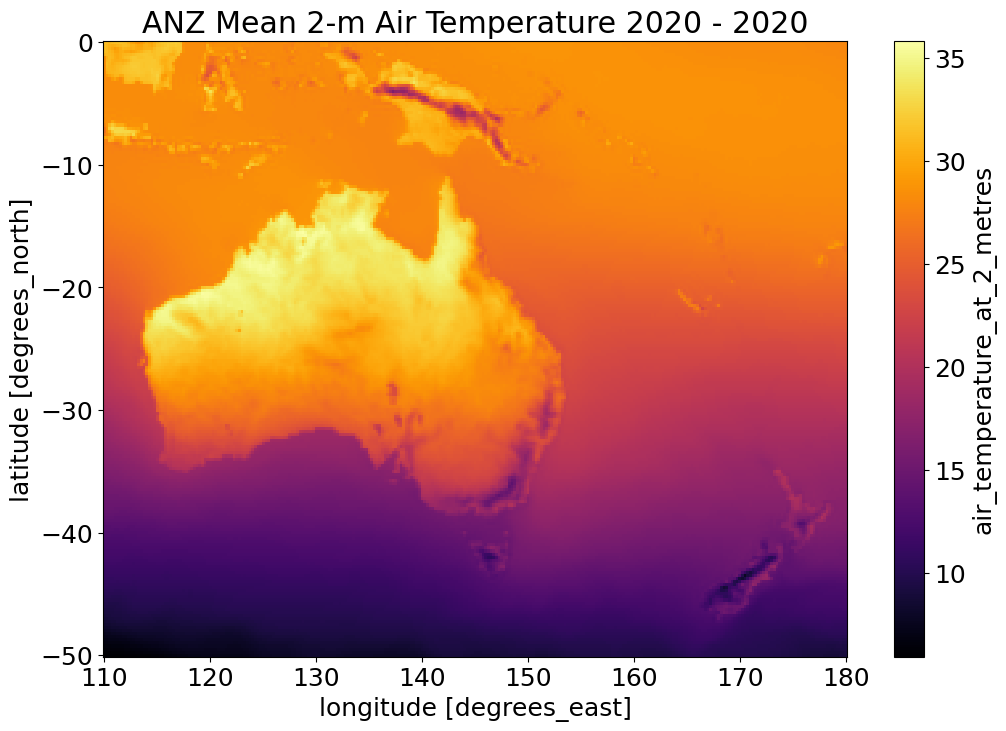

In [36]:
subset_mean.compute()
subset_mean.plot(figsize=(12,8), cmap='inferno')
plt.title(f'ANZ Mean 2-m Air Temperature {start_year} - {end_year}')

## Plot temperature time series for points
This example creates a dataframe table of data for some specific locations defined in the array below - extracting time-series data for only the specific points we are interested in.

Feel free to change the cities and locations!

In [37]:
# location coordinates
locs = [
    {'name': 'Santa Barbara', 'lon': -119.70, 'lat': 34.42},
    {'name': 'Colorado Springs', 'lon': -104.82, 'lat': 38.83},
    {'name': 'Honolulu', 'lon': -157.84, 'lat': 21.29},
    {'name': 'Seattle', 'lon': -122.33, 'lat': 47.61},
    {'name': 'Melbourne', 'lon': 144.95, 'lat': -37.84},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'Santa Barbara', 'lon': 240.3, 'lat': 34.42},
 {'name': 'Colorado Springs', 'lon': 255.18, 'lat': 38.83},
 {'name': 'Honolulu', 'lon': 202.16, 'lat': 21.29},
 {'name': 'Seattle', 'lon': 237.67000000000002, 'lat': 47.61},
 {'name': 'Melbourne', 'lon': 144.95, 'lat': -37.84}]

In [38]:
ds_locs = xr.Dataset()
air_temp_ds = ds

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({'air_temperature_at_2_metres' : var_name}).drop(('lat', 'lon'))

    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    Santa Barbara     (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>
    Colorado Springs  (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>
    Honolulu          (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>
    Seattle           (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>
    Melbourne         (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>

In [39]:
ds_locs

<xarray.Dataset>
Dimensions:           (time0: 8784)
Coordinates:
  * time0             (time0) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    Santa Barbara     (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>
    Colorado Springs  (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>
    Honolulu          (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>
    Seattle           (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>
    Melbourne         (time0) float32 dask.array<chunksize=(384,), meta=np.ndarray>

Now lets extract the data - this should be fast because everything is in worker memory

In [40]:
ds_locs = client.persist(ds_locs)
progress(ds_locs)

VBox()

### Convert to dataframe
Conversion between an xarray DataArray into a pandas DataFrame (table) as time series data

In [41]:
df_f = ds_locs.to_dataframe()
df_f

,Santa Barbara,Colorado Springs,Honolulu,Seattle,Melbourne
time0,,,,,
2020-01-01 00:00:00,16.662506,-2.587494,24.537506,8.912506,20.225006
2020-01-01 01:00:00,15.287506,-4.837494,24.725006,8.662506,21.100006
2020-01-01 02:00:00,13.975006,-5.649994,24.787506,9.037506,22.162506
2020-01-01 03:00:00,12.600006,-6.087494,24.725006,9.850006,23.412506
2020-01-01 04:00:00,11.100006,-5.837494,24.600006,10.350006,23.537506
...,...,...,...,...,...
2020-12-31 19:00:00,11.537506,3.787506,24.350006,8.287506,15.412506
2020-12-31 20:00:00,11.850006,4.037506,24.412506,8.350006,16.600006
2020-12-31 21:00:00,12.850006,4.600006,24.287506,8.475006,18.100006


In [42]:
df_f.describe()

,Santa Barbara,Colorado Springs,Honolulu,Seattle,Melbourne
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,16.705339,9.382416,24.630922,11.722907,14.310282
std,5.673730,11.413450,1.294596,5.848819,5.654137
min,3.225006,-25.462494,18.412506,-0.962494,0.850006
25%,12.100006,-0.024994,23.725006,7.162506,10.412506
50%,16.787506,9.225006,24.787506,11.287506,13.537506
75%,20.787506,18.037506,25.662506,15.850006,17.475006
max,36.037506,35.100006,27.225006,33.475006,42.475006


In [43]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Santa Barbara     8784 non-null   float32
 1   Colorado Springs  8784 non-null   float32
 2   Honolulu          8784 non-null   float32
 3   Seattle           8784 non-null   float32
 4   Melbourne         8784 non-null   float32
dtypes: float32(5)
memory usage: 240.2 KB


### Plot temperature timeseries

We'll first re-sample the data from hourly to daily maximums.  Note the number of entries / size of the dataset is reduced.

In [44]:
rs = df_f.resample('D').max()
rs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Freq: D
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Santa Barbara     366 non-null    float32
 1   Colorado Springs  366 non-null    float32
 2   Honolulu          366 non-null    float32
 3   Seattle           366 non-null    float32
 4   Melbourne         366 non-null    float32
dtypes: float32(5)
memory usage: 10.0 KB


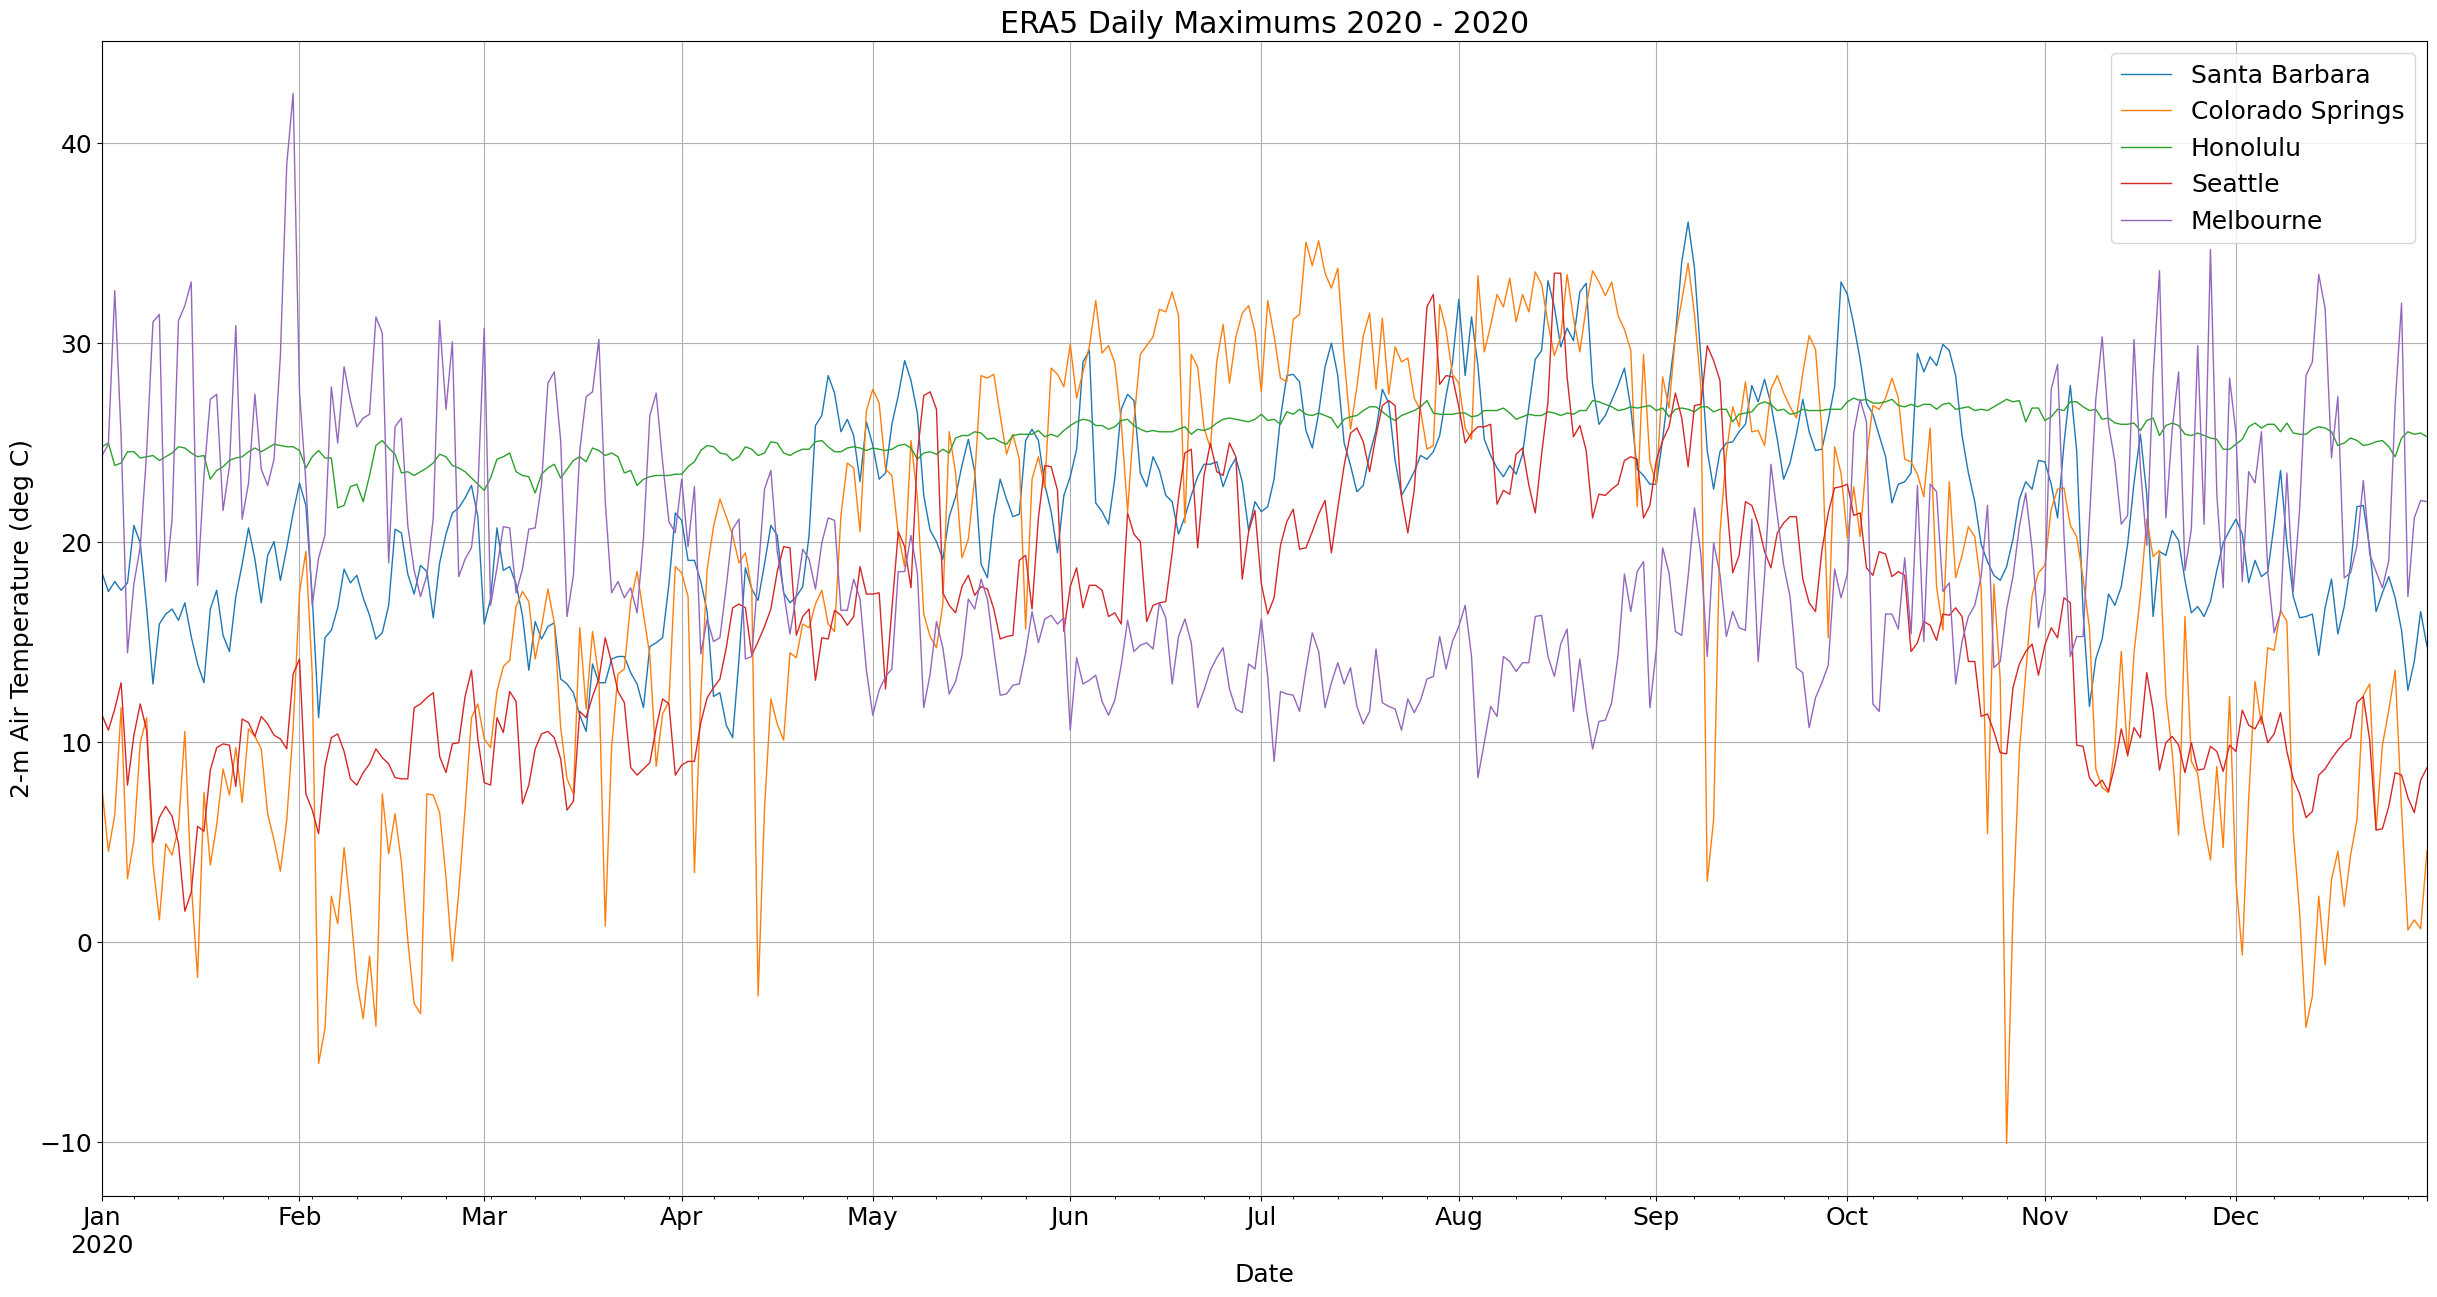

In [45]:
matplotlib.rcParams['lines.linewidth'] = 1.0
matplotlib.rcParams['lines.linestyle'] = 'solid'
ax = rs.plot(figsize=(30, 15), title=f"ERA5 Daily Maximums {start_year} - {end_year}", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg C)')
plt.show()

## Cluster scale down

When we are temporarily done with the cluster we can scale it down to save on costs

In [ ]:
client.cancel(ds)
client.cancel(temp_mean)

In [ ]:
client.close()

In [ ]:
ecs.update_service(cluster=cluster, service=workerservice, desiredCount=0)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=[workerservice])

Optional - stop the scheduler

In [ ]:
ecs.update_service(cluster=cluster, service=schedulerservice, desiredCount=0)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=[schedulerservice])